# Sparse coding (Olshausen & Field, 1996) モデル


このノートブックでは視覚におけるSparse codingのモデル ([Olshausen & Field, *Nature*. 1996](https://www.nature.com/articles/381607a0))を解説し、Pythonによる実装を行います。コードを実行したい場合は<https://github.com/takyamamoto/SparseCoding-OlshausenField-Model>をCloneして`sparse-coding.ipynb`か、`train.py`を実行してください。

## ガボールフィルタ


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io as sio
import cv2

OpenCVでgaborフィルタを作成。

In [4]:
gabor = [cv2.getGaborKernel((30, 30), 3.0, i*np.pi/4, 10, 0.5, 0) for i in range(4)]

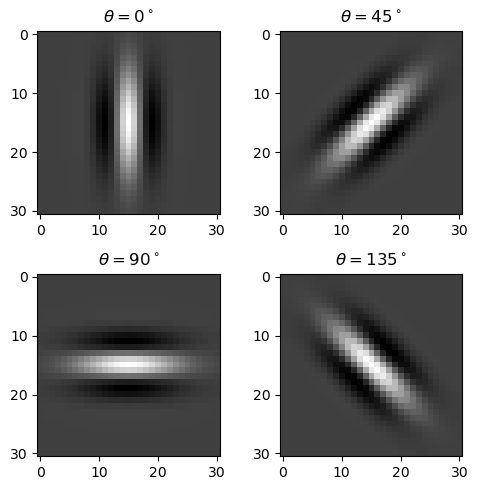

In [5]:
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(gabor[i], cmap="gray")
plt.tight_layout()

$\theta=0$の時の波形を確認。

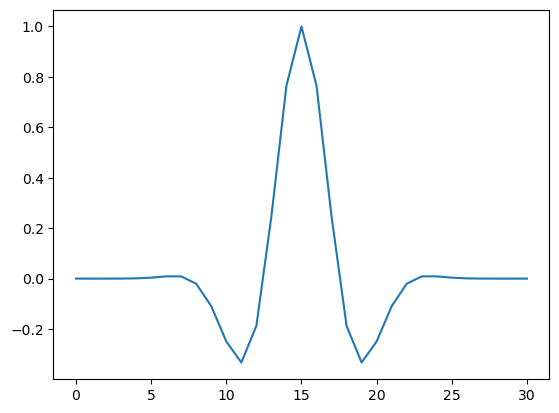

In [6]:
plt.plot(gabor[0][15, :])

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできます。MATLABコードもダウンロードできますが、手元では動かすことができませんでした。`IMAGES.mat`には白色化された10枚の自然画像が記録されています。

In [7]:
!wget "http://www.rctn.org/bruno/sparsenet/IMAGES.mat"
!wget "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"

'wget' is not recognized as an internal or external command,
operable program or batch file.


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('./datasets/IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('./datasets/IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']
print(imgs.shape, imgs_raw.shape)

(512, 512, 10) (512, 512, 10)


画像を確認。

(512, 512, 10)


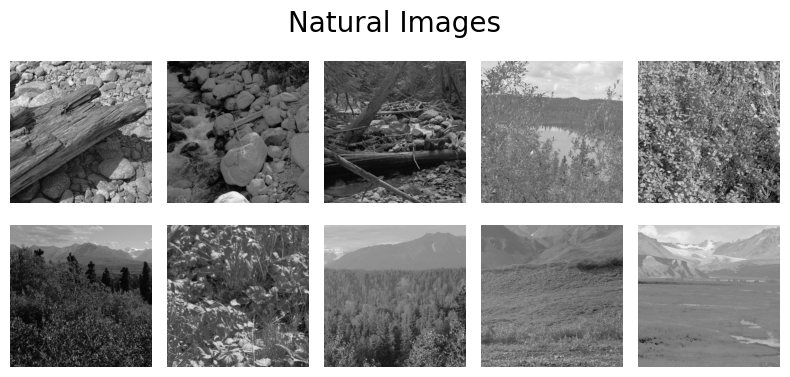

In [12]:
# Plot datasets
fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9) 
print(imgs_raw.shape)

1枚目の画像に対してgaborフィルタをかける。

In [13]:
out = [cv2.filter2D(imgs_raw[:, :, 0], -1, gabor[i]) for i in range(4)] 

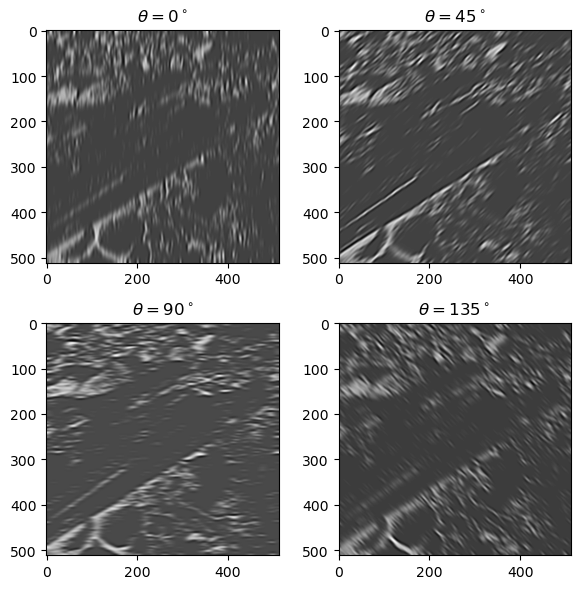

In [14]:
plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(out[i], cmap="gray")
plt.tight_layout()

In [15]:
out_sum = np.sum(np.array(out), axis=0)

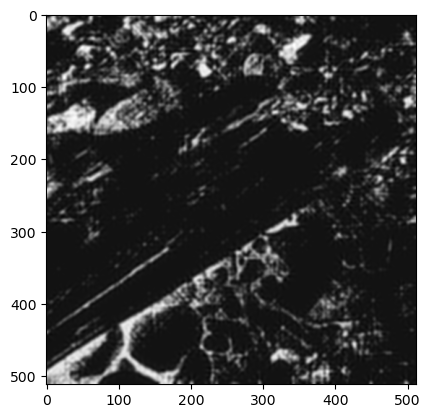

In [16]:
plt.imshow(out_sum, cmap="gray")

## 画像のsparse coding

画像 $\boldsymbol{I} (\boldsymbol{x})$が基底関数(basis function) $\Phi = [\phi_i(\boldsymbol{x})]$の線形和 (係数は$\boldsymbol{r}=[r_i] $)で表されるとします。

$$
\boldsymbol{I}(\boldsymbol{x}) = \sum_i r_i \phi_i (\boldsymbol{x}) + \epsilon(\boldsymbol{x})= \Phi \boldsymbol{r} + \epsilon(\boldsymbol{x})
\tag{1}
$$

ただし、$\boldsymbol{x}$は画像上の座標, $\epsilon$は平均0のGaussianノイズを表します。また、$\boldsymbol{r}$は入力よりも高次の神経細胞の活動、$\Phi$は重み行列とします。

Sparse codingは、少数の基底で画像 (や目的変数)を表すことを目的とします。要は(1)式において、ほとんどが0で、一部だけ0以外の値を取るという疎 (=sparse, スカスカ)な係数$\boldsymbol{r}$を求めたい、ということです。なお、sparse codingは統計学や機械学習において一般に使用される語であることを念のために言っておきます。

## 目的関数の設定
Sparse codingのための目的関数(cost function) $E$は(2)式のようになります。

$$
E = \underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(\frac{r_i}{\sigma}\right)}_{\text{sparseness of}\ r_i} \tag{2}
$$

ただし、$\lambda$は正則化係数、$\sigma$は定数(scaling constant)です。ここで、第一項が復元損失、第二項が罰則項 (係数が大きな値とならないようにする項)となっています。

$S(x)$としては $\ln(1+x^2), |x|$ などの関数が用いられます。これらの関数は原点において尖った形状をしており、解が0になりやすくなっています。描画すると以下のようになります。

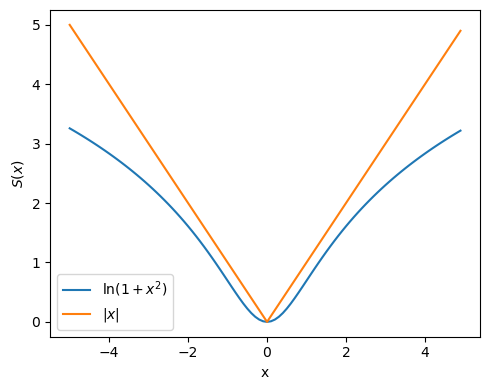

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.1)

plt.figure(figsize=(5,4))
plt.plot(x, np.log(1+x**2), label=r"$\ln(1+x^2)$")
plt.plot(x, np.abs(x), label=r"$|x|$")
plt.xlabel("x")
plt.ylabel(r"$S(x)$")
plt.legend()
plt.tight_layout()
plt.show()

次節からはSparse codingに基づいて最適な$\boldsymbol{r}$と$\Phi$を得る方法について説明していきます。

##  Locally Competitive Algorithm (LCA) 
$\boldsymbol{r}$の勾配法による更新則は、目的関数 $E$の微分により次のように得られます。

$$
\begin{aligned}
\frac{d \boldsymbol{r}}{dt} &= -\frac{\eta_\boldsymbol{r}}{2}\frac{\partial E}{\partial \boldsymbol{r}}\\
&=\eta_\boldsymbol{r} \cdot\left[\Phi^T (\boldsymbol{I}-\Phi\boldsymbol{r})- \frac{\lambda}{2\sigma}S'\left(\frac{r_i}{\sigma}\right)\right]
\end{aligned}\tag{3}
$$

ただし、$\eta_{\boldsymbol{r}}$は学習率です。この式により$\boldsymbol{r}$が収束するまで最適化しますが、単なる勾配法ではなく、(Olshausen & Field, 1996)では**共役勾配法** (conjugate gradient method)を用いています。しかし、共役勾配法は実装が煩雑で非効率であるため、より効率的かつ生理学的な妥当性の高い学習法として、**LCA**  (locally competitive algorithm)が提案されています ([Rozell et al., *Neural Comput*. 2008](https://www.ece.rice.edu/~eld1/papers/Rozell08.pdf))。LCAは**側抑制** (local competition, lateral inhibition)と**閾値関数** (thresholding function)を用いる更新則です。LCAによる更新を行うRNNは通常のRNNとは異なり、コスト関数(またはエネルギー関数)を最小化する動的システムです。このような機構はHopfield networkで用いられているために、Olshausenは"the Hopfield trick"と呼んでいます。

### 軟判定閾値関数を用いる場合 (ISTA)
$S(x)=|x|$とした場合の閾値関数を用いる手法として**ISTA**(Iterative Shrinkage Thresholding Algorithm)があります。ISTAはL1-norm正則化項に対する近接勾配法で、要はLasso回帰に用いる勾配法です。

解くべき問題は(4)式で表されます。

$$
\boldsymbol{r} = \mathop{\rm arg~min}\limits_{\boldsymbol{r}}\left\{\|\boldsymbol{I}-\Phi\boldsymbol{r}\|^2_2+\lambda\|\boldsymbol{r}\|_1\right\}\tag{4}
$$

詳細は後述しますが、次のように更新することで解が得られます。

1. $\boldsymbol{r}(0)$を要素が全て0のベクトルで初期化
2. $\boldsymbol{r}_*(t+1)=\boldsymbol{r}(t)+\eta_\boldsymbol{r}\cdot \Phi^T(\boldsymbol{I}-\Phi\boldsymbol{r}(t))$
3. $\boldsymbol{r}(t+1) = S_\lambda(\boldsymbol{r}_*(t+1))$
4. $\boldsymbol{r}$が収束するまで2と3を繰り返す

ここで$S_\lambda(\cdot)$は**軟判定閾値関数** (Soft thresholding function)と呼ばれ、(5)式で表されます。

$$
S_\lambda(y)= 
\begin{cases} 
y-\lambda & (y>\lambda)\\ 
0 & (-\lambda\leq y\leq\lambda)\\ 
 y+\lambda & (y<-\lambda) 
\end{cases}\tag{5}
$$

$S_\lambda(\cdot)$を描画すると次のようになります。

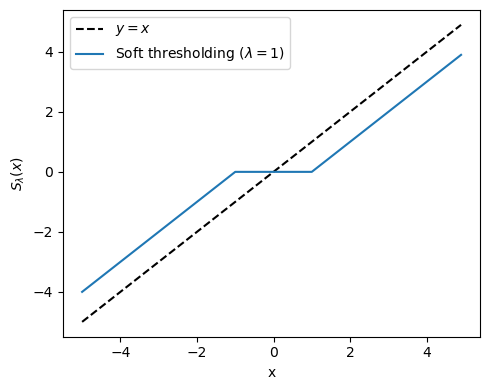

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# thresholding function of S(x)=|x|
def soft_thresholding_func(x, lmda):
    return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

plt.figure(figsize=(5,4))
x = np.arange(-5, 5, 0.1)
y = soft_thresholding_func(x, 1)
plt.plot(x, x, "k--", label=r"$y=x$")
plt.plot(x, y, label=r"Soft thresholding ($\lambda=1$)")
plt.xlabel("x")
plt.ylabel(r"$S_\lambda (x)$")
plt.legend()
plt.tight_layout()
plt.show()

なお、Soft thresholding関数は次の目的関数$C$を最小化する$x$を求めることで導出できます。

$$
C=\frac{1}{2}(y-x)^2+\lambda |x| \tag{6}
$$

ただし、$x, y, \lambda$はスカラー値であるとします。$|x|$が微分できませんが、これは場合分けを考えることで解決します。$x\geq 0$を考えると、(6)式は

$$
C=\frac{1}{2}(y-x)^2+\lambda x = \{x-(y-\lambda)\}^2+\lambda(y-\lambda) \tag{7}
$$

となります。ここで、(7)式の最小値を与える$x$は場合分けをして考えると、$y-\lambda\geq0$のとき二次関数の頂点を考えて$x=y-\lambda$となります。 一方で$y-\lambda<0$のときは$x\geq0$において単調増加な関数となるので、最小となるのは$x=0$のときです。同様の議論を$x\leq0$に対しても行うことで (5)式が得られます。

硬判定閾値関数 (hard thresholding function)に似た形状をしていることが分かります。

## 重み行列の更新則
$\boldsymbol{r}$が収束したら勾配法により$\Phi$を更新します。

$$
\begin{aligned}
\Delta \phi_i(\boldsymbol{x}) &= -\eta \frac{\partial E}{\partial \Phi}\\
&=\eta\cdot\left[\left([\boldsymbol{I}-\Phi\boldsymbol{r}\right)\boldsymbol{r}^T\right]
\end{aligned}\tag{8}
$$

## Sparse coding networkの実装
### ネットワークの構造
入力層を含め2層の単純な構造です。今回は、入力はランダムに切り出した16×16 (＝256)の画像パッチとし、これを入力層の256個のニューロンが受け取るとします。入力層のニューロンは次層の100個のニューロンに投射するとします。100個のニューロンが入力をSparseに符号化するようにその活動および重み行列を最適化します。下図はネットワークの構造図です。ただし、$a_i$は本記事における$r_i$に対応します。

![fig2a](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/images/sparse-coding_figs/fig2a.JPG?raw=1)
<div style="text-align: right;"> (Olshausen, 2002; Fig. 2a)</div>

### ネットワークの実装
LCAに基づき、ネットワークを実装します。基本的には`__call__`関数を実行して係数`r`と重み行列`Phi`を更新します。外部から呼び出し、`r`を収束するまで更新し、収束したときに`training`を`True`にして`Phi`を更新します。また、閾値関数としては`soft_thresholding_func`, `ln_thresholding_func`, `cauchy_thresholding_func`の3つを使用できるようにしています。どれを用いるかはコメントアウトを外すなどして変更してください。

In [19]:
class OlshausenField1996Model:
    def __init__(self, num_inputs, num_units, batch_size,
                 lr_r=1e-2, lr_Phi=1e-2, lmda=5e-3):
        self.lr_r = lr_r # learning rate of r
        self.lr_Phi = lr_Phi # learning rate of Phi
        self.lmda = lmda # regularization parameter
        
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.batch_size = batch_size
        
        # Weights
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1/self.num_units)

        # activity of neurons
        self.r = np.zeros((self.batch_size, self.num_units))
    
    def initialize_states(self):
        self.r = np.zeros((self.batch_size, self.num_units))
        
    def normalize_rows(self):
        self.Phi = self.Phi / np.maximum(np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8)

    # thresholding function of S(x)=|x|
    def soft_thresholding_func(self, x, lmda):
        return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

    def calculate_total_error(self, error):
        recon_error = np.mean(error**2)
        sparsity_r = self.lmda*np.mean(np.abs(self.r)) 
        return recon_error + sparsity_r
        
    def __call__(self, inputs, training=True):
        # Updates                
        error = inputs - self.r @ self.Phi.T
        
        r = self.r + self.lr_r * error @ self.Phi
        self.r = self.soft_thresholding_func(r, self.lmda)
        
        if training:  
            error = inputs - self.r @ self.Phi.T
            dPhi = error.T @ self.r
            self.Phi += self.lr_Phi * dPhi
            
        return error, self.r

### モデルの定義
上で実装したネットワークを`model`として定義します。また、シミュレーションで用いる定数などを初期化しておきます。

In [20]:
# Simulation constants
H, W, num_images = imgs.shape
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)

eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors

# Define model
model = OlshausenField1996Model(num_inputs=sz**2, num_units=num_units,
                                batch_size=batch_size)

### シミュレーションの実行
シミュレーションを実行します。外側の`for loop`では画像パッチの作成と`r`の初期化を行います。内側の`for loop`では`r`が収束するまで更新を行い、収束したときに重み行列`Phi`を更新します。

In [ ]:
# Run simulation
for n in range(num_iter):
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-sz, batch_size)
    beginy = np.random.randint(0, H-sz, batch_size)

    inputs_list = []

    # Get images randomly
    for i in range(batch_size):        
        idx = np.random.randint(0, num_images)
        img = imgs[:, :, idx]
        clop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
        img_show = clop.reshape(sz, sz)
        inputs_list.append(clop - np.mean(clop))
        
    inputs = np.array(inputs_list) # Input image patches

    model.initialize_states() # Reset states
    model.normalize_rows() # Normalize weights
    
    # Input an image patch until latent variables are converged 
    r_tm1 = model.r # set previous r (t minus 1)

    for t in range(nt_max):
        # Update r without update weights 
        error, r = model(inputs, training=False)
        dr = r - r_tm1 

        # Compute norm of r
        dr_norm = np.linalg.norm(dr, ord=2) / (eps + np.linalg.norm(r_tm1, ord=2))
        r_tm1 = r # update r_tm1
        
        # Check convergence of r, then update weights
        if dr_norm < eps:
            error, r = model(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if t >= nt_max-2: 
            print("Error at patch:", n)
            print(dr_norm)
            break
   
    error_list.append(model.calculate_total_error(error)) # Append errors

    # Print moving average error
    if n % 100 == 99:  
        print("iter: "+str(n+1)+"/"+str(num_iter)+", Moving error:",
              np.mean(error_list[n-99:n]))

(250, 256)


RuntimeError: No active exception to reraise

### 訓練中の損失の描画

訓練中の損失の変化を描画してみましょう。損失が低下し、学習が進行したことが分かります。

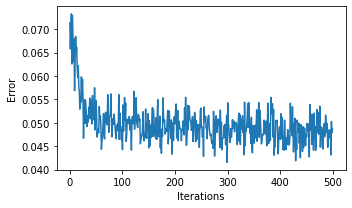

In [ ]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.show()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\Phi$)を可視化してみましょう。

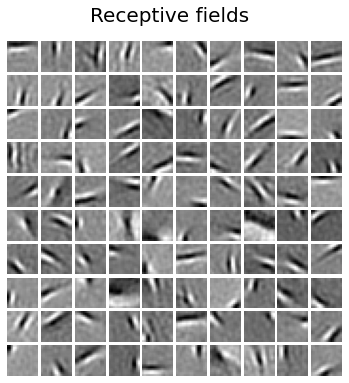

In [ ]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(num_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表します。Gaborフィルタ様の局所受容野が得られており、これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似しています。

## ICAとPCAによる自然画像の分析
参考までに自然画像に対してICAとPCAを実行してみます。ICAを実行することはSparse codingを行うことと同じであり、結果としてGaborフィルタ様の局所受容野が得られます。一方で、PCAを実行しても広域的な受容野しか得られません ([Sanger TD, 1989](https://papers.nips.cc/paper/139-an-optimality-principle-for-unsupervised-learning))。

### ライブラリのimport
`sklearn.decomposition`を持ちます。

In [2]:
from sklearn.decomposition import FastICA, PCA

### 画像パッチの作成
白色化前の画像を用いた方がPCAの結果が綺麗です。

In [8]:
# Simulation constants
H, W, num_images = imgs_raw.shape

num_patches = 15000
patchs_list = []
w, h = 16, 16 # patch size

# generate patches
for i in tqdm(range(num_patches)):
    i = np.random.randint(0, num_images)
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-w-1)
    beginy = np.random.randint(0, H-h-1)
    img_clopped = imgs_raw[beginy:beginy+h, beginx:beginx+w, i]
    patchs_list.append(img_clopped.flatten())

patches = np.array(patchs_list)

### ICAの実行

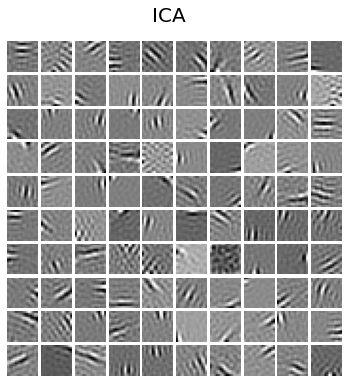

In [9]:
# perform ICA
n_comp = 100
ica = FastICA(n_components=n_comp)
ica.fit(patches)
ica_filters = ica.components_

# plot filters
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(ica_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("ICA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

他にはK-means法を用いることでもGaborフィルタを得ることはできます。
- [Gabors / Primary Visual Cortex “Simple Cells” from an Image — skimage v0.13.1 docs](https://scikit-image.org/docs/0.13.x/auto_examples/features_detection/plot_gabors_from_astronaut.html#sphx-glr-auto-examples-features-detection-plot-gabors-from-astronaut-py)

### PCAの実行

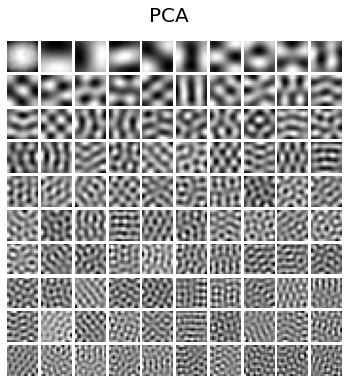

In [ ]:
# perform PCA
pca = PCA(n_components=n_comp)
pca.fit(patches)
pca_filters = pca.components_

# plot filters
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(pca_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("PCA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

## まとめ
- Sparse codingのモデルを実装した。
- LCA (locally competitive algorithm)は効率良くsparce codingをneural networkで実現するための手法。
- Sparce codingによりV1の単純型細胞と同様のGaborフィルタが得られる。

## 参考文献
### 論文
- Olshausen BA, Field DJ. [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://www.nature.com/articles/381607a0). *Nature*. 1996;381(6583):607–609. [Data and Code](http://www.rctn.org/bruno/sparsenet/), [pdf](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf)
- Olshausen BA. [Principles of Image Representation in Visual Cortex](https://groups.oist.jp/sites/default/files/img/ocnc/2004/Olshausen.pdf). *The Visual Neurosciences*. 2002.
- Rozell CJ, Johnson DH, Baraniuk RG, Olshausen BA. [Sparse coding via thresholding and local competition in neural circuits](http://www.mit.edu/~9.54/fall14/Classes/class07/Palm.pdf). *Neural Comput*. 2008;20(10):2526‐2563.
- Mayo P, Holmes R, Achim A. [Iterative Cauchy Thresholding: Regularisation with a heavy-tailed prior](https://arxiv.org/abs/2003.12507). arXiv. 2020.
- Paiton DM. [Analysis and applications of the Locally Competitive Algorithm](https://escholarship.org/uc/item/1wz289gt). UC Berkeley. 2019.

### GitHubで確認した他の実装例
- https://github.com/lpjiang97/sparse-coding

### Olshausen先生の講義
- [Bruno Olshausen: “Sparse coding in brains and machines”(Stanford talks)](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)
- https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-LCA.pdf

### スパースモデリング
- [今日からできるスパースモデリング](http://www-adsys.sys.i.kyoto-u.ac.jp/mohzeki/Presentation/lecturenote20150909.pdf)
- [スパースモデリングを超初歩から始めてみた。(ISTAを実装した) - MAEA2’s diary](http://maea2.hatenablog.com/entry/2017/03/06/235519)